In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json, csv, math
from matplotlib import animation
from matplotlib.patches import Circle as MatCircle
from matplotlib.collections import LineCollection
import matplotlib.patheffects as pe

### Compare single disk scattering distribution and multiple disk scattering distribution (averaged)

Text(0.5, 1.0, 'Intensity Distribution')

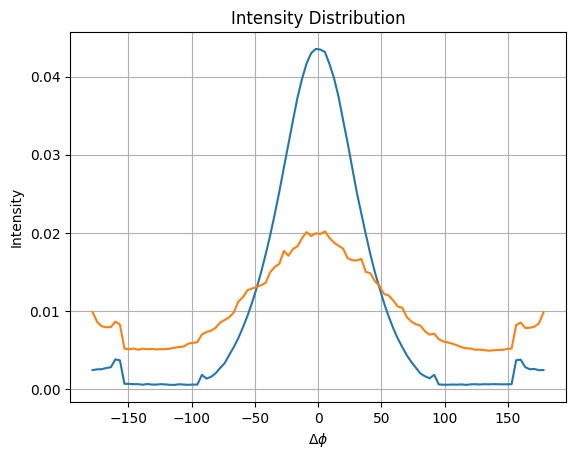

In [2]:
num_bins = 100
single = np.fromfile('single_sigma_0.00_n2_1.50.bin', dtype=np.float64)
multiple = np.fromfile('multiple_avg_sigma_0.00_n2_1.50_radius_1.0.bin', dtype=np.float64)
single = np.roll(single, num_bins//2)         # plot forward scattering in the middle
multiple = np.roll(multiple, num_bins//2)     # plot forward scattering in the middle

bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers*180/np.pi, single, label='Single Cicle')
plt.plot(bin_centers*180/np.pi, multiple, label='Multiple Circles')
plt.grid()
plt.xlabel('$\Delta \phi$')
plt.ylabel('Intensity')
plt.title('Intensity Distribution')

### Animation of tracing rays through multiple circles

Saved tracing.mp4 and tracing.gif


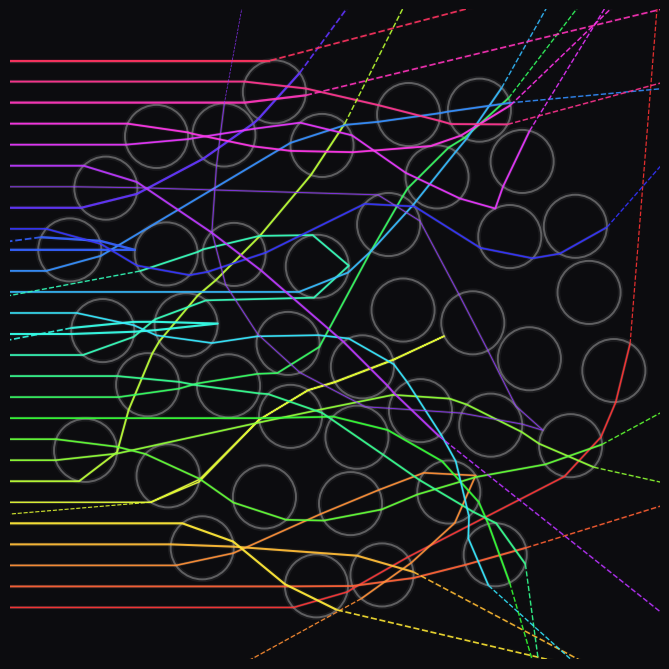

In [17]:
# Load data
circles_csv = "circles.csv"
rays_jsonl = "rays.json"

circles = []
with open(circles_csv, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        circles.append((float(row["cx"]), float(row["cy"]), float(row["r"])))
cx0, cy0, R = circles[0]
small_circles = circles[1:]

rays_pts, out_angles, energies = [], [], []
with open(rays_jsonl, "r") as f:
    for line in f:
        o = json.loads(line)
        pts = np.array(o["points"], float)
        if len(pts) < 2: 
            continue
        rays_pts.append(pts)
        if "out_angle" in o:
            out_angles.append(float(o["out_angle"]))
        else:
            v = pts[-1] - pts[-2]
            out_angles.append(math.atan2(v[1], v[0]))
        if "energy" in o:
            energies.append(float(o["energy"]))
        else:
            energies.append(float(o.get("energy", 1.0)))

rays_pts = rays_pts
out_angles = np.array(out_angles)
energies = np.array(energies)
if len(rays_pts) == 0:
    raise SystemExit("No rays to plot.")

# Style
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(6.5, 6.5), facecolor="#0c0c0f")
ax.set_aspect("equal", adjustable="box")

# tight canvas that fills the figure
ax.set_position([0, 0, 1, 1])
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xticks([]); ax.set_yticks([])
ax.set_facecolor('none')
plt.rcParams['savefig.facecolor'] = fig.get_facecolor()

# bounds (small pad)
pad = 0.03
ax.set_xlim(-R * (1 + pad), R * (1 + pad))
ax.set_ylim(-R * (1 + pad), R * (1 + pad))

# circles
for (cx, cy, r) in small_circles:
    base = (1, 1, 1, 0.30)
    glow = (1, 1, 1, 0.06)
    ax.add_patch(MatCircle((cx, cy), r, fill=False, lw=4.0, ec=glow))
    ax.add_patch(MatCircle((cx, cy), r, fill=False, lw=1.4, ec=base))

# line collections
N = len(rays_pts)
empty = np.empty((0, 2))

core_lc = LineCollection([empty]*N, linewidths=0.8, colors="white", alpha=0.95)
glow_lc = LineCollection([empty]*N, linewidths=2.2, colors="white", alpha=0.05)
core_lc.set_path_effects([pe.withStroke(linewidth=1.8, foreground=(1,1,1,0.15))])
exit_core = LineCollection([empty]*N, linewidths=0.6, colors="white", alpha=0.9, linestyles="--")
exit_glow = LineCollection([empty]*N, linewidths=1.8, colors="white", alpha=0.04, linestyles="--")
ax.add_collection(glow_lc)
ax.add_collection(core_lc)
ax.add_collection(exit_glow)
ax.add_collection(exit_core)

# widths & colors
emin, emax = float(np.min(energies)), float(np.max(energies))
e_norm = (energies - emin) / (emax - emin + 1e-12)
core_lc.set_linewidths(0.6 + 1.0*e_norm)
glow_lc.set_linewidths(1.5 + 2.5*e_norm)
exit_core.set_linewidths(0.5 + 0.8*e_norm)
exit_glow.set_linewidths(1.2 + 2.0*e_norm)

import colorsys
colors = [colorsys.hsv_to_rgb(i/N, 0.8, 1.0) for i in range(N)]
core_lc.set_color(colors)
glow_lc.set_color([(r,g,b,0.07) for (r,g,b) in colors])
exit_core.set_color([(r,g,b,0.90) for (r,g,b) in colors])
exit_glow.set_color([(r,g,b,0.06) for (r,g,b) in colors])

# animation
max_len = max(len(p) for p in rays_pts)
tail_steps = 22
total_frames = max_len + tail_steps
Lmax = 1.5 * R

def init():
    return (core_lc, glow_lc, exit_core, exit_glow)

def animate(frame):
    # in-medium polylines
    segs_core, segs_glow = [], []
    for pts in rays_pts:
        n = min(frame, len(pts))
        seg = pts[:n, :] if n >= 2 else empty
        segs_core.append(seg)
        segs_glow.append(seg)
    core_lc.set_segments(segs_core)
    glow_lc.set_segments(segs_glow)

    # exit segments
    grow = max(0, frame - max_len)
    if grow > 0:
        t = min(1.0, grow / tail_steps)
        segs_exit = []
        for pts, ang in zip(rays_pts, out_angles):
            p0 = pts[-1]
            p1 = p0 + Lmax * t * np.array([math.cos(ang), math.sin(ang)])
            segs_exit.append(np.vstack([p0, p1]))
        exit_core.set_segments(segs_exit)
        exit_glow.set_segments(segs_exit)
    else:
        exit_core.set_segments([empty]*N)
        exit_glow.set_segments([empty]*N)

    return (core_lc, glow_lc, exit_core, exit_glow)

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=total_frames, interval=33, blit=False, repeat=False)

# tight save
ani.save("tracing.mp4", writer="ffmpeg", fps=20, dpi=180)
ani.save("tracing.gif", writer="pillow", fps=20)
print("Saved tracing.mp4 and tracing.gif")